In [3]:
"""
Downloading data
"""
from nba_api.stats.endpoints import leaguegamefinder
import pandas as pd
import numpy as np
import time

years = range(1, 25)
seasons = [f"20{i:02d}-{(i+1)%100:02d}" for i in years]

to_merge = []
for s in seasons:
    time.sleep(1)
    finder = leaguegamefinder.LeagueGameFinder(
        season_nullable=s,
        season_type_nullable="Regular Season",
        league_id_nullable='00'
    )

    game_df = finder.get_data_frames()[0]
    to_merge.append(game_df)

games_df = pd.concat(to_merge)

In [18]:
"""
Merging games into single rows
"""

def merge_games(df):
    df['HOME'] = df['MATCHUP'].str.contains('vs.') 
    home_df = df[df['HOME']].copy()
    away_df = df[~df['HOME']].copy()

    merged = home_df.merge(
        away_df,
        on='GAME_ID',
        suffixes=('_home', '_away')
    )
    print(merged.columns)
    merged = merged[[
        'SEASON_ID_home', 'GAME_DATE_home', 'TEAM_ABBREVIATION_home', 'TEAM_ABBREVIATION_away',
        'PTS_home', 'PTS_away'
    ]].rename(columns={
        'SEASON_ID_home' : 'sid',
        'GAME_DATE_home': 'date',
        'TEAM_ABBREVIATION_home': 'team_home',
        'TEAM_ABBREVIATION_away': 'team_away',
        'PTS_home': 'score_home',
        'PTS_away': 'score_away'
    })

    merged["win_home"] = (merged["score_home"] > merged["score_away"]).astype(int)

    merged['date'] = pd.to_datetime(merged['date'])
    merged = merged.sort_values('date').reset_index(drop=True)
    return merged

games = merge_games(games_df)
games


Index(['SEASON_ID_home', 'TEAM_ID_home', 'TEAM_ABBREVIATION_home',
       'TEAM_NAME_home', 'GAME_ID', 'GAME_DATE_home', 'MATCHUP_home',
       'WL_home', 'MIN_home', 'PTS_home', 'FGM_home', 'FGA_home',
       'FG_PCT_home', 'FG3M_home', 'FG3A_home', 'FG3_PCT_home', 'FTM_home',
       'FTA_home', 'FT_PCT_home', 'OREB_home', 'DREB_home', 'REB_home',
       'AST_home', 'STL_home', 'BLK_home', 'TOV_home', 'PF_home',
       'PLUS_MINUS_home', 'HOME_home', 'SEASON_ID_away', 'TEAM_ID_away',
       'TEAM_ABBREVIATION_away', 'TEAM_NAME_away', 'GAME_DATE_away',
       'MATCHUP_away', 'WL_away', 'MIN_away', 'PTS_away', 'FGM_away',
       'FGA_away', 'FG_PCT_away', 'FG3M_away', 'FG3A_away', 'FG3_PCT_away',
       'FTM_away', 'FTA_away', 'FT_PCT_away', 'OREB_away', 'DREB_away',
       'REB_away', 'AST_away', 'STL_away', 'BLK_away', 'TOV_away', 'PF_away',
       'PLUS_MINUS_away', 'HOME_away'],
      dtype='object')


,sid,date,team_home,team_away,score_home,score_away,win_home
0,22001,2001-10-30,NYK,WAS,93,91,1
1,22001,2001-10-30,MIN,PHI,83,74,1
2,22001,2001-10-30,UTA,MIL,112,119,0
3,22001,2001-10-30,CLE,BOS,89,108,0
4,22001,2001-10-30,SAS,LAC,109,98,1
...,...,...,...,...,...,...,...
28825,22024,2025-04-13,MIN,UTA,116,105,1
28826,22024,2025-04-13,POR,LAL,109,81,1
28827,22024,2025-04-13,CLE,IND,118,126,0
28828,22024,2025-04-13,PHI,CHI,102,122,0


In [5]:
import numpy as np
import pandas as pd
import math
from scipy.optimize import minimize

EPS = 1e-12

games_sorted = games.sort_values("date").reset_index(drop=False)
cut1 = games_sorted["date"].quantile(0.8)
tr_idx = games_sorted.loc[games_sorted["date"] < cut1, "index"].to_numpy()

p_home = (games["win_home"] == 1).mean()
HCA = 400 * math.log10(p_home / (1 - p_home))

def _elo_logloss_for_params(games_df, K, HCA, alpha, scale=400.0):
    """
    Compute total negative log-likelihood for given Elo params on a chronologically
    ordered DataFrame with columns: sid, date, team_home, team_away, score_home, score_away.
    """
    teams = pd.unique(games_df[['team_home','team_away']].values.ravel())
    elo = {t: 1500.0 for t in teams}
    prev_sid = object()
    nll = 0.0

    for _, r in games_df.iterrows():
        # season reset (shrink to mean)
        if r['sid'] != prev_sid:
            for t in elo:
                elo[t] = alpha * elo[t] + (1.0 - alpha) * 1500.0

        Ra, Rb = elo[r.team_home], elo[r.team_away]

        # probability of home win using learned scale (400 by default)
        # elo_diff = Ra - Rb + HCA
        Ea = 1.0 / (1.0 + 10.0 ** (-(Ra - Rb + HCA) / scale))

        y = 1.0 if r.score_home > r.score_away else 0.0
        nll += -(y * np.log(Ea + EPS) + (1 - y) * np.log(1 - Ea + EPS))

        # update ratings with margin-of-victory multiplier
        margin = abs(r.score_home - r.score_away)
        mult = np.log1p(margin) * 2.2 / ((Ra - Rb) * 0.001 + 2.2)
        delta = K * mult * (y - Ea)

        elo[r.team_home] = Ra + delta
        elo[r.team_away] = Rb - delta
        prev_sid = r['sid']

    return nll

def fit_elo_params(games_train, K0=20.0, HCA0=60.0, alpha0=0.55, scale0=400.0):
    """
    Learn K, HCA, alpha (season reset), and scale by ML on the TRAIN window only.
    games_train must be chronologically sorted.
    """
    bounds = [(5.0, 80.0),     # K
              (0.0, 120.0),    # HCA (Elo points)
              (0.20, 0.95),    # alpha (keep some shrink)
              (250.0, 550.0)]  # scale in the Elo->prob sigmoid (400 standard)

    x0 = np.array([K0, HCA0, alpha0, scale0], dtype=float)

    def objective(x):
        K, HCA, alpha, scale = x
        return _elo_logloss_for_params(games_train, K, HCA, alpha, scale)

    res = minimize(objective, x0=x0, method="L-BFGS-B", bounds=bounds)
    K, HCA, alpha, scale = res.x
    return float(K), float(HCA), float(alpha), float(scale)

# build the TRAIN slice and ensure chronological order
train_df = games.loc[tr_idx].sort_values("date").reset_index(drop=True)

# a reasonable HCA starting guess from your earlier empirical calc
K_star, HCA_star, alpha_star, scale_star = fit_elo_params(
    train_df, K0=20.0, HCA0=HCA, alpha0=0.55, scale0=400.0
)
print("Learned params:", K_star, HCA_star, alpha_star, scale_star)

Learned params: 9.389090813085769 76.18639609784859 0.5427645196624447 400.77247729219175


In [6]:
"""
Updating Elos
"""

import math

p_home = (games["win_home"] == 1).mean()
HCA = 400 * math.log10(p_home / (1 - p_home))
K = 20


def update_elo(games_df, K=K, HCA=HCA, alpha=0.55, scale=400):
    elo = {team: 1500 for team in pd.unique(games_df[['team_home', 'team_away']].values.ravel())}
    records = []

    prev_sid = object() 
    for idx, row in games_df.iterrows():
        if row['sid'] != prev_sid:
            for team, rating in elo.items():
                elo[team] = alpha * rating + (1-alpha)* 1500

        home, away = row['team_home'], row['team_away']
        score_home, score_away = row['score_home'], row['score_away']
        win_home = 1 if score_home > score_away else 0

        Ra, Rb = elo[home], elo[away]
        Ea = 1 / (1 + 10 ** ((Rb - Ra + HCA) / scale))
        margin = abs(score_home - score_away)
        mult = np.log1p(margin) * 2.2 / ((Ra - Rb) * 0.001 + 2.2)
        delta = K * mult * (win_home - Ea)

        elo[home] += delta
        elo[away] -= delta

        games_df.loc[idx, 'elo_pre_home'] = Ra
        games_df.loc[idx, 'elo_pre_away'] = Rb
        games_df.loc[idx, 'elo_post_home'] = elo[home]
        games_df.loc[idx, 'elo_post_away'] = elo[away]

        prev_sid = row['sid']

    games_df['elo_diff'] = games_df['elo_pre_home'] - games_df['elo_pre_away'] + HCA

    return elo

elos = update_elo(games, K_star, HCA_star, alpha_star, scale_star)
games

,sid,date,team_home,team_away,score_home,score_away,win_home,elo_pre_home,elo_pre_away,elo_post_home,elo_post_away,elo_diff
0,22001,2001-10-30,NYK,WAS,93,91,1,1500.000000,1500.000000,1506.268566,1493.731434,76.186396
1,22001,2001-10-30,MIN,PHI,83,74,1,1500.000000,1500.000000,1513.138308,1486.861692,76.186396
2,22001,2001-10-30,UTA,MIL,112,119,0,1500.000000,1500.000000,1492.341009,1507.658991,76.186396
3,22001,2001-10-30,CLE,BOS,89,108,0,1500.000000,1500.000000,1488.966130,1511.033870,76.186396
4,22001,2001-10-30,SAS,LAC,109,98,1,1500.000000,1500.000000,1514.178615,1485.821385,76.186396
...,...,...,...,...,...,...,...,...,...,...,...,...
28825,22024,2025-04-13,MIN,UTA,116,105,1,1641.853758,1273.693534,1645.000158,1270.547134,444.346620
28826,22024,2025-04-13,POR,LAL,109,81,1,1467.006438,1613.824468,1493.520352,1587.310554,-70.631634
28827,22024,2025-04-13,CLE,IND,118,126,0,1704.470944,1600.218892,1693.830368,1610.859468,180.438449
28828,22024,2025-04-13,PHI,CHI,102,122,0,1289.996284,1516.052122,1285.225130,1520.823276,-149.869442


In [7]:
import pandas as pd
import numpy as np

WIN_WINDOW = 10

def add_features(games: pd.DataFrame, win_window: int = WIN_WINDOW, fill_rest: int = 7) -> pd.DataFrame:
    df = games.copy()
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    if "sid" not in df.columns:
        raise ValueError("Input must include 'sid' (season id).")
    df["sid"] = pd.to_numeric(df["sid"], errors="coerce")

    if "win_home" not in df.columns:
        if {"score_home", "score_away"}.issubset(df.columns):
            df["win_home"] = (df["score_home"] > df["score_away"]).astype(int)
        else:
            raise ValueError("Need 'win_home' or both 'score_home' and 'score_away'.")

    # stable row id for same-day ties
    df = df.reset_index(drop=False).rename(columns={"index": "row_id"})

    # ---------- per-team logs (vectorized) ----------
    home = df[["sid","date","team_home","score_home","score_away","win_home","row_id"]].rename(
        columns={"team_home":"team","score_home":"pf","score_away":"pa","win_home":"win"}
    )
    home["is_home"] = 1

    away = df[["sid","date","team_away","score_home","score_away","win_home","row_id"]].rename(
        columns={"team_away":"team","score_home":"pa","score_away":"pf","win_home":"win"}
    )
    away["is_home"] = 0
    away["win"] = 1 - away["win"]

    logs = pd.concat([home, away], ignore_index=True)
    logs = logs.sort_values(["team","sid","date","row_id"], kind="mergesort").reset_index(drop=True)

    # per-game margin
    logs["pt_diff"] = (logs["pf"] - logs["pa"]).astype(float)

    g = logs.groupby(["team","sid"], sort=False)

    # ---------- season-to-date BEFORE this game (index-safe; no shift) ----------
    # 1) Overall season +/- before game
    logs["spdiff"] = (g["pt_diff"].cumsum() - logs["pt_diff"]).astype(float)

    # 2) Off/Def efficiency before game (per-game averages)
    gp_incl   = g.cumcount() + 1              # games including current
    gp_prev   = gp_incl - 1                   # games before current
    pf_cum_in = g["pf"].cumsum()
    pa_cum_in = g["pa"].cumsum()
    pf_pre    = pf_cum_in - logs["pf"]        # totals before game
    pa_pre    = pa_cum_in - logs["pa"]
    logs["off_eff"] = np.where(gp_prev > 0, pf_pre / gp_prev, np.nan)
    logs["def_eff"] = np.where(gp_prev > 0, pa_pre / gp_prev, np.nan)

    # 3) Venue-specific (home/away) win% and point-diff before game
    logs["home_game"]  = (logs["is_home"] == 1).astype(int)
    logs["away_game"]  = (logs["is_home"] == 0).astype(int)
    logs["home_win"]   = logs["win"] * logs["home_game"]
    logs["away_win"]   = logs["win"] * logs["away_game"]
    logs["home_pdiff"] = logs["pt_diff"] * logs["home_game"]
    logs["away_pdiff"] = logs["pt_diff"] * logs["away_game"]

    # cumulative including current
    h_games_in = g["home_game"].cumsum()
    a_games_in = g["away_game"].cumsum()
    h_wins_in  = g["home_win"].cumsum()
    a_wins_in  = g["away_win"].cumsum()
    h_pd_in    = g["home_pdiff"].cumsum()
    a_pd_in    = g["away_pdiff"].cumsum()

    # pre-game (subtract current row's contribution)
    h_games = h_games_in - logs["home_game"]
    a_games = a_games_in - logs["away_game"]
    h_wins  = h_wins_in  - logs["home_win"]
    a_wins  = a_wins_in  - logs["away_win"]
    h_pd    = h_pd_in    - logs["home_pdiff"]
    a_pd    = a_pd_in    - logs["away_pdiff"]

    logs["home_win_pct"]    = np.where(h_games > 0, h_wins / h_games, np.nan)
    logs["away_win_pct"]    = np.where(a_games > 0, a_wins / a_games, np.nan)
    logs["home_point_diff"] = np.where(h_games > 0, h_pd / h_games, np.nan)
    logs["away_point_diff"] = np.where(a_games > 0, a_pd / a_games, np.nan)

    # ---------- rest / rw_pct / streak ----------
    logs["prev_date"] = g["date"].shift(1)
    logs["rest_days"] = ((logs["date"] - logs["prev_date"]).dt.days - 1).clip(lower=0)

    logs["prev_win"] = g["win"].shift(1)
    logs["rw_pct"] = (g["prev_win"]
                      .rolling(win_window, min_periods=1)
                      .mean()
                      .reset_index(level=[0,1], drop=True))

    logs["prev_sign"] = logs["prev_win"].map({1: 1, 0: -1})
    def _streak_from_prev(gr):
        cur, out = 0, []
        for s in gr["prev_sign"]:
            if pd.isna(s):
                cur = 0
            else:
                s = int(s)
                cur = (cur + 1 if cur > 0 else 1) if s > 0 else (cur - 1 if cur < 0 else -1)
            out.append(cur)
        gr = gr.copy()
        gr["streak"] = out
        return gr
    logs = logs.groupby(["team","sid"], group_keys=False).apply(_streak_from_prev)

    # ---------- Elo PRE rolling (leak-free) ----------
    if {"elo_pre_home", "elo_pre_away"}.issubset(df.columns):
        # map each per-team log row to the corresponding pre-game Elo from df
        logs["elo_pre"] = np.where(
            logs["is_home"] == 1,
            df.loc[logs["row_id"].values, "elo_pre_home"].values,
            df.loc[logs["row_id"].values, "elo_pre_away"].values
        ).astype(float)

        def _elo_roll(gr, w=5):
            e = gr["elo_pre"].astype(float)
            gr = gr.copy()
            gr["elo_pre_ma5"]       = e.rolling(w, min_periods=3).mean()
            # slope (linear trend) of Elo_pre within window
            gr["elo_pre_slope5"]    = e.rolling(w, min_periods=3).apply(
                lambda x: np.polyfit(np.arange(len(x)), x, 1)[0], raw=False
            )
            de = e.diff()  # Δ Elo_pre between games (still pre-game to pre-game)
            gr["elo_pre_diff_ma5"]  = de.rolling(w, min_periods=3).mean()  # momentum
            gr["elo_pre_diff_std5"] = de.rolling(w, min_periods=3).std()   # volatility
            return gr

        logs = logs.groupby(["team","sid"], group_keys=False).apply(_elo_roll)
    else:
        # if Elo pre columns are missing, create NaNs so downstream code still runs
        logs["elo_pre_ma5"] = np.nan
        logs["elo_pre_slope5"] = np.nan
        logs["elo_pre_diff_ma5"] = np.nan
        logs["elo_pre_diff_std5"] = np.nan

    # ---------- spread back to game rows ----------
    h = logs.rename(columns={
        "team":"team_home",
        "rest_days":"rest_h","rw_pct":"rw_pct_h","streak":"streak_h",
        "spdiff":"spdiff_h",
        "off_eff":"off_eff_h","def_eff":"def_eff_h",
        "home_win_pct":"home_win_pct_h",
        "home_point_diff":"home_point_diff_h",
        "elo_pre_ma5":"elo_pre_ma5_h",
        "elo_pre_slope5":"elo_pre_slope5_h",
        "elo_pre_diff_ma5":"elo_momentum_h",
        "elo_pre_diff_std5":"elo_volatility_h",
    })[["sid","date","team_home",
        "rest_h","rw_pct_h","streak_h","spdiff_h",
        "off_eff_h","def_eff_h",
        "home_win_pct_h","home_point_diff_h",
        "elo_pre_ma5_h","elo_pre_slope5_h","elo_momentum_h","elo_volatility_h"]]

    a = logs.rename(columns={
        "team":"team_away",
        "rest_days":"rest_a","rw_pct":"rw_pct_a","streak":"streak_a",
        "spdiff":"spdiff_a",
        "off_eff":"off_eff_a","def_eff":"def_eff_a",
        "away_win_pct":"away_win_pct_a",
        "away_point_diff":"away_point_diff_a",
        "elo_pre_ma5":"elo_pre_ma5_a",
        "elo_pre_slope5":"elo_pre_slope5_a",
        "elo_pre_diff_ma5":"elo_momentum_a",
        "elo_pre_diff_std5":"elo_volatility_a",
    })[["sid","date","team_away",
        "rest_a","rw_pct_a","streak_a","spdiff_a",
        "off_eff_a","def_eff_a",
        "away_win_pct_a","away_point_diff_a",
        "elo_pre_ma5_a","elo_pre_slope5_a","elo_momentum_a","elo_volatility_a"]]

    out = (df.drop(columns="row_id")
             .merge(h, on=["sid","date","team_home"], how="left")
             .merge(a, on=["sid","date","team_away"], how="left"))

    # fills
    out["rest_h"]   = out["rest_h"].fillna(fill_rest)
    out["rest_a"]   = out["rest_a"].fillna(fill_rest)
    out["rw_pct_h"] = out["rw_pct_h"].fillna(0.5)
    out["rw_pct_a"] = out["rw_pct_a"].fillna(0.5)
    out["streak_h"] = out["streak_h"].fillna(0).astype(int)
    out["streak_a"] = out["streak_a"].fillna(0).astype(int)

    out["home_win_pct_h"]    = out["home_win_pct_h"].fillna(0.5)
    out["away_win_pct_a"]    = out["away_win_pct_a"].fillna(0.5)
    out["home_point_diff_h"] = out["home_point_diff_h"].fillna(0.0)
    out["away_point_diff_a"] = out["away_point_diff_a"].fillna(0.0)

    out["off_eff_h"] = out["off_eff_h"].fillna(0.0)
    out["off_eff_a"] = out["off_eff_a"].fillna(0.0)
    out["def_eff_h"] = out["def_eff_h"].fillna(0.0)
    out["def_eff_a"] = out["def_eff_a"].fillna(0.0)

    # Elo rolling fills (sensible defaults)
    if "elo_pre_home" in out.columns:
        out["elo_pre_ma5_h"] = out["elo_pre_ma5_h"].fillna(out["elo_pre_home"])
    else:
        out["elo_pre_ma5_h"] = out["elo_pre_ma5_h"].fillna(0.0)
    if "elo_pre_away" in out.columns:
        out["elo_pre_ma5_a"] = out["elo_pre_ma5_a"].fillna(out["elo_pre_away"])
    else:
        out["elo_pre_ma5_a"] = out["elo_pre_ma5_a"].fillna(0.0)

    for c in ["elo_pre_slope5_h","elo_momentum_h","elo_volatility_h",
              "elo_pre_slope5_a","elo_momentum_a","elo_volatility_a"]:
        out[c] = out[c].fillna(0.0)

    # diffs
    out["rest_diff"]          = out["rest_h"] - out["rest_a"]
    out["rw_pct_diff"]        = out["rw_pct_h"] - out["rw_pct_a"]
    out["streak_diff"]        = out["streak_h"] - out["streak_a"]
    out["spdiff_diff"]        = out["spdiff_h"] - out["spdiff_a"]
    out["off_eff_diff"]       = out["off_eff_h"] - out["off_eff_a"]
    out["def_eff_diff"]       = out["def_eff_h"] - out["def_eff_a"]
    out["net_off_diff"]       = out["off_eff_h"] - out["def_eff_a"]
    out["net_def_diff"]       = out["def_eff_h"] - out["off_eff_a"]
    out["hvenue_winpct_diff"] = out["home_win_pct_h"] - out["away_win_pct_a"]
    out["hvenue_pdiff_diff"]  = out["home_point_diff_h"] - out["away_point_diff_a"]
    out["b2b_home"] = (out["rest_h"] == 0).astype(int)
    out["b2b_away"] = (out["rest_a"] == 0).astype(int)

    # Elo-based diffs & interaction
    out["elo_pre_ma5_diff"]    = out["elo_pre_ma5_h"]    - out["elo_pre_ma5_a"]
    out["elo_pre_slope5_diff"] = out["elo_pre_slope5_h"] - out["elo_pre_slope5_a"]
    out["elo_momentum_diff"]   = out["elo_momentum_h"]   - out["elo_momentum_a"]
    out["elo_volatility_diff"] = out["elo_volatility_h"] - out["elo_volatility_a"]
    out["elo_momentum_x_rest"] = out["elo_momentum_diff"] * out["rest_diff"]

    out["momentum_index"] = (
        0.4 * out["rw_pct_diff"] +
        0.3 * out["streak_diff"]/5 +
        0.3 * np.tanh(out["spdiff_diff"]/20)
    )

    out['elo_x_momentum'] = out['elo_diff'] * out['momentum_index']
    out['elo_x_rest'] = out['elo_diff'] * out['rest_diff']
    out['off_def_product'] = out['off_eff_diff'] * out['def_eff_diff']
    out['venue_x_streak'] = out['hvenue_winpct_diff'] * out['streak_diff']



    return out


games_d = add_features(games)
games_d

/var/folders/vc/9pky90h50tjdhdw9xnj_zsbc0000gn/T/ipykernel_41710/316138917.py:108: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  logs = logs.groupby(["team","sid"], group_keys=False).apply(_streak_from_prev)
/var/folders/vc/9pky90h50tjdhdw9xnj_zsbc0000gn/T/ipykernel_41710/316138917.py:132: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  logs = logs.groupby(["team","sid"], group_keys=False).apply(_elo_roll)


,sid,date,team_home,team_away,score_home,score_away,win_home,elo_pre_home,elo_pre_away,elo_post_home,...,elo_pre_ma5_diff,elo_pre_slope5_diff,elo_momentum_diff,elo_volatility_diff,elo_momentum_x_rest,momentum_index,elo_x_momentum,elo_x_rest,off_def_product,venue_x_streak
0,22001,2001-10-30,NYK,WAS,93,91,1,1500.000000,1500.000000,1506.268566,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
1,22001,2001-10-30,MIN,PHI,83,74,1,1500.000000,1500.000000,1513.138308,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
2,22001,2001-10-30,UTA,MIL,112,119,0,1500.000000,1500.000000,1492.341009,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
3,22001,2001-10-30,CLE,BOS,89,108,0,1500.000000,1500.000000,1488.966130,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
4,22001,2001-10-30,SAS,LAC,109,98,1,1500.000000,1500.000000,1514.178615,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28825,22024,2025-04-13,MIN,UTA,116,105,1,1641.853758,1273.693534,1645.000158,...,370.548466,-2.502127,0.970568,-2.301748,0.0,0.760000,337.703431,0.0,-27.442158,1.275000
28826,22024,2025-04-13,POR,LAL,109,81,1,1467.006438,1613.824468,1493.520352,...,-111.510442,-12.924295,-12.670491,0.261534,-0.0,-0.700000,49.442144,-0.0,-5.930651,-0.200000
28827,22024,2025-04-13,CLE,IND,118,126,0,1704.470944,1600.218892,1693.830368,...,100.821313,-3.037148,-3.034872,0.464517,-0.0,0.420000,75.784148,0.0,-13.477970,0.725641
28828,22024,2025-04-13,PHI,CHI,102,122,0,1289.996284,1516.052122,1285.225130,...,-214.088297,-3.940207,-6.537780,-1.866836,-0.0,-0.720000,107.905998,-0.0,30.706904,0.600000


In [8]:
FEATS = ["elo_diff","rest_diff","rw_pct_diff","streak_diff", "spdiff_diff",
         'off_eff_diff', 'def_eff_diff', 'net_off_diff', 'net_def_diff',
         'hvenue_winpct_diff', "hvenue_pdiff_diff", "momentum_index", "b2b_home",
         'b2b_away', 'elo_pre_ma5_diff', 'elo_pre_slope5_diff', 'elo_momentum_diff',
         'elo_volatility_diff', 'elo_momentum_x_rest', 'elo_x_momentum', 'elo_x_rest',
         'off_def_product', 'venue_x_streak']

RAW_FOR_META = [
    "elo_diff",
    "rest_diff"
]

monos = "(" + ",".join(["1"] + ["0"]*(len(FEATS)-1)) + ")"

def time_splits(df, date_col="date", splits=(0.6, 0.2, 0.2)):
    assert abs(sum(splits) - 1.0) < 1e-9
    d = df.sort_values(date_col).reset_index(drop=True)
    cut1 = d[date_col].quantile(splits[0])
    cut2 = d[date_col].quantile(splits[0] + splits[1])
    idx_tr = np.flatnonzero(d[date_col] <  cut1)
    idx_va = np.flatnonzero((d[date_col] >= cut1) & (d[date_col] < cut2))
    idx_te = np.flatnonzero(d[date_col] >= cut2)
    return idx_tr, idx_va, idx_te

idx_tr, idx_va, idx_te = time_splits(games_d, "date", (0.6, 0.2, 0.2))

X = games_d.loc[:, FEATS]
y = games_d["win_home"].astype(int)

X_tr, y_tr = X.iloc[idx_tr], y.iloc[idx_tr]
X_va, y_va = X.iloc[idx_va], y.iloc[idx_va]
X_te, y_te = X.iloc[idx_te], y.iloc[idx_te]

In [9]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit, StratifiedKFold
from sklearn.metrics import log_loss, brier_score_loss, roc_auc_score, accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
import xgboost as xgb
from catboost import CatBoostClassifier


# ------- 0) CV splitter -------
tss_outer = TimeSeriesSplit(n_splits=6) 
tss_inner = StratifiedKFold(n_splits=5, shuffle=False)


# ------- 1) Base learners as pipelines (so LR/MLP get scaling) -------
pipe_xgb = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    tree_method="hist",
    monotone_constraints=monos,
    n_estimators=600,
    learning_rate=0.03,
    n_jobs=-1,
    random_state=42
)

pipe_cat = CatBoostClassifier(
    iterations=500,
    learning_rate=0.03,
    depth=6,
    l2_leaf_reg=3.0,
    eval_metric='Logloss',
    loss_function='Logloss',
    random_state=42,
    verbose=False
)

pipe_lr  = make_pipeline(
    StandardScaler(with_mean=True, with_std=True),
    LogisticRegression(max_iter=1000, solver="lbfgs", penalty="l2", C=1.0, random_state=42)
)

pipe_mlp = make_pipeline(
    StandardScaler(with_mean=True, with_std=True),
    MLPClassifier(
        hidden_layer_sizes=(128, 64),
        activation="relu",
        alpha=1e-4,
        learning_rate_init=1e-3,
        early_stopping=True,
        n_iter_no_change=10,
        max_iter=400,
        random_state=42
    )
)


# ------- 2) Tune each base model (neg_log_loss/Brier) -------
# XGB search space
xgb_dist = {
    "max_depth":        [2,3,4,5,6],
    "min_child_weight": [1,2,3,5],
    "subsample":        [0.6,0.7,0.8,0.9,1.0],
    "colsample_bytree": [0.6,0.7,0.8,0.9,1.0],
    "reg_lambda":       [0.0, 0.5, 1.0, 2.0, 5.0],
    "gamma":            [0.0, 0.1, 0.2],
    "learning_rate":    [0.01, 0.02, 0.03, 0.04, 0.05],
    "n_estimators":     [200, 300, 400, 500, 700]
}
xgb_search = RandomizedSearchCV(
    estimator=pipe_xgb,
    param_distributions=xgb_dist,
    n_iter=40, scoring="neg_log_loss", cv=tss_outer, n_jobs=-1, refit=True, random_state=42
).fit(X_tr, y_tr)
xgb_best = xgb_search.best_estimator_
print('xgb tuned')

# Cat search sapce
cat_dist = {
    "depth": [4,5,6,7],
    "l2_leaf_reg": [1,3,5,7],
    "learning_rate": [0.02,0.03,0.05],
    "iterations": [300,500,700],
    "subsample": [0.7,0.8,1.0]
}
cat_search = RandomizedSearchCV(
    estimator=pipe_cat,
    param_distributions=cat_dist,
    n_iter=20,
    scoring="neg_log_loss",
    cv=tss_outer,
    n_jobs=-1,
    refit=True,
    random_state=42
).fit(X_tr, y_tr)
cat_best = cat_search.best_estimator_
print('cat tuned')

# LR search space
lr_dist = {
    "logisticregression__C":      np.logspace(-5, 5, 100),
    "logisticregression__penalty":["l2"],
    "logisticregression__fit_intercept":[True, False]
}
lr_search = RandomizedSearchCV(
    estimator=pipe_lr, param_distributions=lr_dist,
    n_iter=30, scoring="neg_log_loss", cv=tss_outer, n_jobs=-1, refit=True, random_state=42
).fit(X_tr, y_tr)
lr_best = lr_search.best_estimator_
print('lr tuned')


# MLP search space (keep small to avoid overfit/compute blowup)
mlp_dist = {
    "mlpclassifier__hidden_layer_sizes":[(64,32), (128,64), (128,64,32)],
    "mlpclassifier__alpha":[1e-5, 1e-4, 1e-3],
    "mlpclassifier__learning_rate_init":[5e-4, 1e-3, 2e-3],
    "mlpclassifier__batch_size":[64, 128, 256]
}
mlp_search = RandomizedSearchCV(
    estimator=pipe_mlp, param_distributions=mlp_dist,
    n_iter=25, scoring="neg_log_loss", cv=tss_outer, n_jobs=-1, refit=True, random_state=42
).fit(X_tr, y_tr)
mlp_best = mlp_search.best_estimator_
print('mlp tuned')


# ------- 3) Build the stack with tuned bases -------
base_models = [
    ("xgb",     xgb_best),
    ("cat",      cat_best),
    ("mlp",     mlp_best),
    ("logistic",lr_best)
]

raw_idx = [FEATS.index(n) for n in RAW_FOR_META if n in FEATS]

def make_meta_slicer(n_bases: int, raw_idx: list):
    def _slice(Z):
        # Z shape = (n_samples, 2*n_bases + n_features), because predict_proba gives 2 cols per base
        mcols = 2 * n_bases
        probs = Z[:, :mcols]
        feats = Z[:, mcols:]
        return np.hstack([probs, feats[:, raw_idx]])
    return FunctionTransformer(_slice, validate=False)

meta = make_pipeline(
    make_meta_slicer(n_bases=4, raw_idx=raw_idx),
    StandardScaler(with_mean=True, with_std=True),
    LogisticRegression(
        solver="saga",            # robust, supports elastic-net
        penalty="elasticnet",
        l1_ratio=0.15,            # small L1 to prevent separation
        C=0.1,                   # **stronger regularization** (try 0.02–0.2)
        max_iter=5000,
        tol=1e-3,
        random_state=42
    )
)

stack = StackingClassifier(
    estimators=base_models,
    final_estimator=meta,
    stack_method="predict_proba",   
    passthrough=True,              # try True as an alternative search point
    cv=tss_inner,
    n_jobs=-1
)


# ------- 4) Tune only a few stack/meta knobs -------
stack_dist = {
    "final_estimator__logisticregression__C": np.logspace(-2, 2, 15),
    "final_estimator__logisticregression__l1_ratio": [0.05, 0.15, 0.3],
    # you can also try L2 only by fixing l1_ratio=0 and penalty='l2' if you want
}
stack_search = RandomizedSearchCV(
    estimator=stack,
    param_distributions=stack_dist,
    n_iter=20, scoring="neg_log_loss", cv=tss_outer, n_jobs=-1, refit=True, random_state=42
).fit(X_tr, y_tr)

stack_best = stack_search.best_estimator_


# ------- 5) Evaluate on held-out validation -------
p_va = stack_best.predict_proba(X_va)[:,1]
p_te = stack_best.predict_proba(X_te)[:,1]
yhat = (p_va >= 0.5).astype(int)
print(
    "Val LogLoss:", log_loss(y_va, p_va),
    "| Val Brier:", brier_score_loss(y_va, p_va),
    "| Val AUC:", roc_auc_score(y_va, p_va),
    "| Val Accuracy:", accuracy_score(y_va, yhat)
)

model = stack_best

for name, model in base_models:
    p = model.predict_proba(X_va)[:,1]
    print(f"{name:10s}  LogLoss={log_loss(y_va,p):.4f}  AUC={roc_auc_score(y_va,p):.3f}")


xgb tuned
cat tuned
lr tuned
mlp tuned
Val LogLoss: 0.6178685390260285 | Val Brier: 0.21460783758121438 | Val AUC: 0.7030092112923438 | Val Accuracy: 0.6548073585560569
xgb         LogLoss=0.6189  AUC=0.702
cat         LogLoss=0.6191  AUC=0.701
mlp         LogLoss=0.6219  AUC=0.700
logistic    LogLoss=0.6175  AUC=0.703


In [10]:
# === Safe, single-cell calibration utilities (no custom classes) ===
import numpy as np
from sklearn.base import clone
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import brier_score_loss, log_loss
from scipy.optimize import minimize
import joblib as jl

EPS = 1e-6
def _clip(p):  return np.clip(np.asarray(p, float), EPS, 1 - EPS)
def _logit(p): p = _clip(p); return np.log(p/(1-p))

def beta_fit_regularized(p, y, lam=1e-3):
    """Return theta as a plain dict {'A','B','C','lam'} (pickle-safe)."""
    p = _clip(p); y = np.asarray(y, float); lg = _logit(p)
    def obj(theta):
        A,B,C = theta
        z = A*lg + B*np.log(1-p) + C
        q = 1/(1+np.exp(-z))
        return np.mean((q - y)**2) + lam*(A*A + B*B + C*C)
    A,B,C = minimize(obj, x0=[1.0,0.0,0.0], method="L-BFGS-B").x
    return [float(A),float(B), float(C)]

def beta_apply(p, theta):
    """theta is the dict returned by beta_fit_regularized."""
    p = _clip(p)
    z = theta[0]*_logit(p) + theta[1]*np.log(1-p) + theta[2]
    return _clip(1/(1+np.exp(-z)))

def oof_predict_proba(estimator, X, y, splitter, return_mask=False):
    X = np.asarray(X); y = np.asarray(y)
    oof  = np.full(len(y), np.nan, float)
    mask = np.zeros(len(y), bool)
    for tr, va in splitter.split(X):
        m = clone(estimator).fit(X[tr], y[tr])
        oof[va]  = m.predict_proba(X[va])[:, 1]
        mask[va] = True
    return (oof, mask) if return_mask else oof

def train_calibrated_model(
    estimator,
    X, y,
    splitter=None,          
    reg_lambda=1e-3,
    bundle_path=None       
):
    X = np.asarray(X); y = np.asarray(y)
    if splitter is None:
        splitter = TimeSeriesSplit(n_splits=6)

    # OOF probs for calibration (time-aware)
    p_oof, mask = oof_predict_proba(estimator, X, y, splitter, return_mask=True)
    p_fit, y_fit = p_oof[mask], y[mask]

    # Fit regularized Beta on OOF
    theta = beta_fit_regularized(p_fit, y_fit, lam=reg_lambda)

    # Refit estimator on ALL data for production
    final_model = clone(estimator).fit(X, y)

    # Diagnostics
    diag = {
        "oof_cov": int(mask.sum()),
        "n": int(len(y)),
        "oof_brier_uncal": float(brier_score_loss(y_fit, p_fit)),
        "oof_brier_cal":   float(brier_score_loss(y_fit, beta_apply(p_fit, theta))),
        "oof_logloss_uncal": float(log_loss(y_fit, p_fit)),
        "oof_logloss_cal":   float(log_loss(y_fit, beta_apply(p_fit, theta))),
    }

    if bundle_path:
        jl.dump(
            {"model": final_model,
             "theta": theta
             },
            bundle_path
        )

    return final_model, theta, diag

def load_bundle(path):
    obj = jl.load(path)  # only primitives + sklearn estimators → safe
    return obj["model"], obj["calibration"]["theta"]

def predict_calibrated(model, theta, X_new):
    p_raw = model.predict_proba(np.asarray(X_new))[:, 1]
    return beta_apply(p_raw, theta)

In [11]:
import numpy as np
from sklearn.base import clone
from sklearn.metrics import brier_score_loss

trval_idx = np.r_[idx_tr, idx_va]
order_trval = np.argsort(games_d.loc[trval_idx, "date"].to_numpy())

X_trval = X.iloc[trval_idx].iloc[order_trval].to_numpy()
y_trval = y.iloc[trval_idx].iloc[order_trval].to_numpy()
                                 
final_model, theta, diag = train_calibrated_model(model, X_trval, y_trval,
     splitter=TimeSeriesSplit(n_splits=6, test_size=max(200, int(0.15*len(X_trval))), gap=0),
     reg_lambda=1e-3)

p_te = final_model.predict_proba(X_te)[:,1]
p_cal_te = beta_apply(p_te, theta)
print("TEST Uncal logloss:", log_loss(y_te, p_te), "| Brier:", brier_score_loss(y_te, p_te))
print("TEST Calib logloss:", log_loss(y_te, p_cal_te),   "| Brier:", brier_score_loss(y_te, p_cal_te))
print("TEST AUC (uncal|cal):", roc_auc_score(y_te, p_te), roc_auc_score(y_te, p_cal_te))

TEST Uncal logloss: 0.6243844419938923 | Brier: 0.21735010638422742
TEST Calib logloss: 0.6235022153655828 | Brier: 0.21700263725675195
TEST AUC (uncal|cal): 0.7033911362728208 0.7033911362728208


/Users/jamesvournakis/Desktop/Projects/nba_model/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [12]:
def expected_calibration_error(y_true, y_prob, n_bins=10):
    bins = np.linspace(0, 1, n_bins+1)
    binids = np.digitize(y_prob, bins) - 1
    ece = 0
    for i in range(n_bins):
        mask = binids == i
        if np.any(mask):
            acc = y_true[mask].mean()
            conf = y_prob[mask].mean()
            ece += abs(acc - conf) * mask.mean()
    return ece

ece = expected_calibration_error(y_te, p_cal_te)
print("ECE:", ece)

ECE: 0.024319183929561214


In [13]:
"""
Final Model Evaluation
"""

from sklearn.metrics import (
    log_loss, brier_score_loss, roc_auc_score, accuracy_score, confusion_matrix
)

def evaluate_model_on_test(model, X_te, y_te, threshold=0.5, n_bins=10):

    p = model.predict_proba(X_te)[:, 1]
    p = beta_apply(p, theta)

    yhat = (p >= threshold).astype(int)

    metrics = {
        "log_loss": float(log_loss(y_te, p)),
        "brier": float(brier_score_loss(y_te, p)),
        "roc_auc": float(roc_auc_score(y_te, p)),
        f"accuracy@{threshold}": float(accuracy_score(y_te, yhat)),
    }

    tn, fp, fn, tp = confusion_matrix(y_te, yhat).ravel()
    metrics.update({"TP": int(tp), "FP": int(fp), "TN": int(tn), "FN": int(fn)})

    bins = pd.qcut(p, q=n_bins, duplicates="drop")
    cal_table = (
        pd.DataFrame({"p": p, "y": y_te, "bin": bins})
          .groupby("bin", observed=True)
          .agg(p_mean=("p", "mean"), y_rate=("y", "mean"), n=("y", "size"))
          .reset_index(drop=True)
    )
    cal_table["abs_err"] = (cal_table["p_mean"] - cal_table["y_rate"]).abs()
    metrics[f"calibration_mae({n_bins}-bins)"] = float(
        np.average(cal_table["abs_err"], weights=cal_table["n"])
    )

    return metrics, cal_table

metrics, cal_table = evaluate_model_on_test(model, X_te, y_te, threshold=0.5, n_bins=10)
print(metrics)
cal_table

{'log_loss': 0.6242269211932858, 'brier': 0.2172368023125577, 'roc_auc': 0.7031833890624433, 'accuracy@0.5': 0.6503811503811504, 'TP': 2498, 'FP': 1325, 'TN': 1256, 'FN': 693, 'calibration_mae(10-bins)': 0.02785439398385044}


,p_mean,y_rate,n,abs_err
0,0.271758,0.243945,578,0.027813
1,0.377878,0.358752,577,0.019126
2,0.447660,0.414211,577,0.033448
3,0.506388,0.481802,577,0.024585
4,0.559079,0.544194,577,0.014885
5,0.608755,0.578856,577,0.029899
6,0.661381,0.642981,577,0.018400
7,0.718994,0.663778,577,0.055216
8,0.782390,0.776430,577,0.005960
9,0.872705,0.823529,578,0.049175


Text(0.5, 1.0, 'Reliability Diagram')

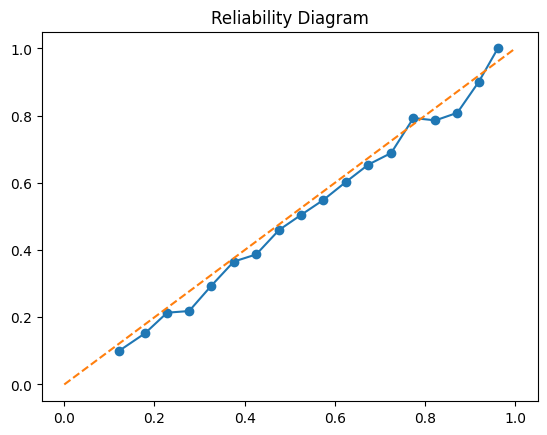

In [14]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

prob_true, prob_pred = calibration_curve(y_te, p_cal_te, n_bins=20)
plt.plot(prob_pred, prob_true, 'o-')
plt.plot([0,1],[0,1],'--')
plt.title('Reliability Diagram')

In [15]:
"""
Saving Initial Elo states
"""

from importlib import reload
import utils 
from datetime import datetime
reload(utils)
from utils import SeasonState, save_state

elos_25 = {}

for team, rating in elos.items():
    elos_25[team] = alpha_star * rating + (1-alpha_star) * 1500

elo_params = {
    'K' : K,
    'HCA' : HCA
}

state = SeasonState(
    season="2025-26",
    last_updated=datetime.now(),
    init_elo=elos_25,
    params={"K": K_star, "HCA": HCA_star, "scale": scale_star}
)

save_state(state, "../states/2025-26_season_state.pkl")

In [16]:
final_model, theta, diag = train_calibrated_model(model, X, y,
     splitter=TimeSeriesSplit(n_splits=6, test_size=max(200, int(0.15*len(X))), gap=0),
     reg_lambda=1e-3, bundle_path="../models/elo_model_ensemble_prod.pkl")
